# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [69]:
# import libraries
import pandas as pd
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, sum, countDistinct, count
import pyspark.sql.functions as sf
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, NullType
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,5)
sns.set_style('whitegrid')
import numpy as np

In [2]:
# create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
!ls

cvModel_dt.model	       Sparkify.ipynb	  spark-warehouse
mini_sparkify_event_data.json  Sparkify-zh.ipynb


In [4]:
# Read in full sparkify dataset
# event_data = "s3n://dsnd-sparkify/sparkify_event_data.json"
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.createOrReplaceTempView("churn_data")

In [8]:
spark.sql("SELECT distinct page FROM churn_data").show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [9]:
# Defining Churn customer by field cancellation confirmation

In [10]:
# Firstly write query to find the customers having cancellation confirmatio
spark.sql("""SELECT DISTINCT userID, 1 as churn
          FROM churn_data
        WHERE page = 'Cancellation Confirmation' """).show(5)

+------+-----+
|userID|churn|
+------+-----+
|100005|    1|
|300007|    1|
|100011|    1|
|100012|    1|
|   101|    1|
+------+-----+
only showing top 5 rows



In [11]:
# Then join it back to the original datasets with defined churn
churn_data = spark.sql("""
SELECT sq1.*, sq2.churn

FROM churn_data as sq1

left join 
(
SELECT DISTINCT userID, 1 as churn
          FROM churn_data
        WHERE page = 'Cancellation Confirmation') as sq2

on sq1.userID = sq2.userID""")

In [12]:
churn_data = churn_data.fillna(0, subset = ['churn'])

In [13]:
churn_data.groupby('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|241636|
+-----+------+



## Convert timestamp to time

In [14]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
churn_data = churn_data.withColumn("date_time", get_time(churn_data.ts)).withColumn("date", get_date(churn_data.ts))

In [15]:
churn_data.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+-------------------+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|churn|          date_time|      date|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+-------------------+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|2018-10-01 00:01:57|2018-10-01|


## Drop Null Values

In [16]:
churn_data.count()
#Count before drop NA

286500

In [17]:
churn_data.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+-------------------+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|churn|          date_time|      date|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+-------------------+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|2018-10-01 00:01:57|2018-10-01|
|Five Iron Frenzy|Logged In|    

In [18]:
churn_data.dropna(how = "any")

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: int, date_time: string, date: string]

In [19]:
churn_data.count()
#Count after drop NA

286500

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Feature Engineering logic
What are the potential reason for churn and incorporate these features in the model to predict the customer churn:
1. Customer taste and availability of music
 * - If the customer liked/ listened to most popular music (played by a large number of people). Then this customer more likely finds songs he/she likes on the platform. This needs then below features:
 * - Song total played by a number of times
 * - Song total played by a number of people
2. Customer lock-in (if the customer has spent already a lot of time in Sparkify,  it becomes difficult to change platform.)
 * - How many days have the customer been with the platform (Max timestamp - min timestamp)
 * - How many active days the customer with the platform (Count distinct timestamp days)
 * - Days active/ Days total
 * - Customer played songs total
3. Other existing features to convert to numeric
 * - Gender
 * - Free or Paid customer

In [20]:
churn_data.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: int, date_time: string, date: string]

### Feature 1 Customer Taste

In [21]:
song_agg = churn_data.filter(churn_data.song != 'null').groupby("song").agg(count("userId").alias('number_of_played_times'), 
                                         countDistinct("userId").alias('number_of_played_users'))

In [22]:
song_agg.show(5)

+--------------------+----------------------+----------------------+
|                song|number_of_played_times|number_of_played_users|
+--------------------+----------------------+----------------------+
|              Heaven|                    86|                    58|
|Never Gonna Be Al...|                    50|                    37|
|Autumn Leaves (Al...|                     3|                     3|
|             Sitting|                    17|                    16|
|What's About To G...|                     1|                     1|
+--------------------+----------------------+----------------------+
only showing top 5 rows



In [23]:
song_df = song_agg.toPandas()

In [24]:
len(song_df)

58480

In [25]:
song_df.describe()

,number_of_played_times,number_of_played_users
count,58480.000000,58480.000000
mean,3.900616,3.454224
std,13.901180,7.002902
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,1153.000000,190.000000


In [39]:
song_df.sort_values(by = 'number_of_played_times', ascending = False, inplace = True)

In [40]:
top_100_by_played_times = song_df.iloc[:99, :3]

In [49]:
top_100_by_played_times.head()

,song,number_of_played_times,number_of_played_users
15878,You're The One,1153,190
7939,Undo,1026,176
27710,Revelry,854,177
7940,Sehr kosmisch,728,172
16475,Horn Concerto No. 4 in E flat K495: II. Romanc...,641,164


In [50]:
#top_100_by_played_times.number_of_played_times.values

Text(0.5,1,'Songs played times distribution')

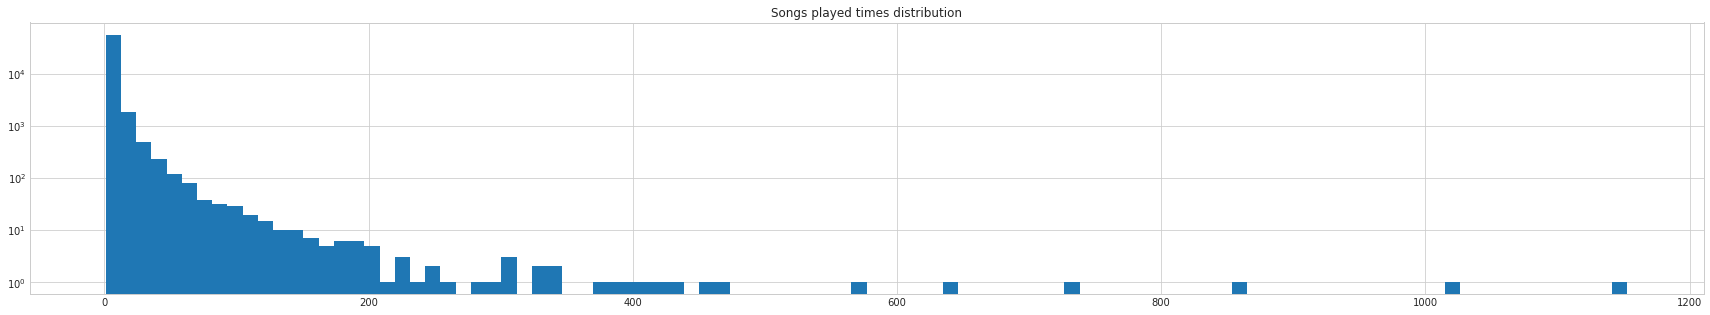

In [70]:
plt.hist( song_df.number_of_played_times.values, bins = 100, log = True)
plt.title("Songs played times distribution")

In [23]:
churn_data_w_song_attribute = churn_data.join(song_agg, churn_data.song == song_agg.song, how = 'left').drop(song_agg.song)

In [24]:
churn_data_w_song_attribute.show(5)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------+-------------+--------------------+------+-----+-------------------+----------+--------------------+----------------------+----------------------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|status|           ts|           userAgent|userId|churn|          date_time|      date|                song|number_of_played_times|number_of_played_users|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------+-------------+--------------------+------+-----+-------------------+----------+--------------------+----------------------+----------------------+
|Skeeter Davis|Logged In|  Dominic|     M|          126|  Torres|155.21914| paid|Chicago-Napervill...|   PUT|Nex

### F2 Feature Customer Lock-in

In [25]:
# Function to return null when 0.
nullif = udf(lambda x: None if x ==0 else x, IntegerType())

user_agg = churn_data_w_song_attribute.groupby("userId").agg(min("ts").alias('min_timestamp'), 
    max("ts").alias('max_timestamp'), avg("number_of_played_times").alias('avg_nbr_of_played_times'),
    avg("number_of_played_users").alias('avg_nbr_of_played_users'),
    countDistinct("date").alias('days_customer_active'), countDistinct("song").alias('played_songs_total'),
    countDistinct("sessionId").alias('played_sessions_total'), count("userId").alias('played_activity_total') )\
    .withColumn(
            'days_customer_with_sparkify', 
            ((col("max_timestamp") - col("min_timestamp") ) /(1000*60*60*24)).cast(IntegerType())  + 1  )\
    .withColumn('days_active_vs_days_total', 
              ( col("days_customer_active")/ nullif(col("days_customer_with_sparkify") ) ) )

In [26]:
user_agg.show(5)

+------+-------------+-------------+-----------------------+-----------------------+--------------------+------------------+---------------------+---------------------+---------------------------+-------------------------+
|userId|min_timestamp|max_timestamp|avg_nbr_of_played_times|avg_nbr_of_played_users|days_customer_active|played_songs_total|played_sessions_total|played_activity_total|days_customer_with_sparkify|days_active_vs_days_total|
+------+-------------+-------------+-----------------------+-----------------------+--------------------+------------------+---------------------+---------------------+---------------------------+-------------------------+
|100010|1539003534000|1542823952000|      56.27272727272727|      26.62181818181818|                   7|               269|                    7|                  381|                         45|      0.15555555555555556|
|200002|1538393430000|1542324354000|      35.75968992248062|      21.10594315245478|                   7|   

### F3 Other Features from Existing data

In [27]:
churn_data_w_song_attribute.groupby('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



In [28]:
churn_data_w_song_attribute.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [29]:
# Function to return null when 0.
nullif = udf(lambda x: None if x ==0 else x, IntegerType())
gender_convert = udf(lambda x: 1 if x =='M' else 0, IntegerType())
free_paid_convert = udf(lambda x: 1 if x =='free' else 0, IntegerType())

user_agg = churn_data_w_song_attribute.withColumn('gender_conv', gender_convert(col("gender")))\
    .withColumn('level_conv', free_paid_convert(col("level")))\
    .groupby("userId").agg(min("ts").alias('min_timestamp'), 
            max("ts").alias('max_timestamp'), avg("number_of_played_times").alias('avg_nbr_of_played_times'),
            avg("number_of_played_users").alias('avg_nbr_of_played_users'),
            avg("gender_conv").alias('gender'),
            avg("level_conv").alias('level_conv'),
            countDistinct("date").alias('days_customer_active'), countDistinct("song").alias('played_songs_total'),
            countDistinct("sessionId").alias('played_sessions_total'), count("userId").alias('played_activity_total'), 
            max("churn").alias('churn'))\
    .withColumn(
            'days_customer_with_sparkify', 
            ((col("max_timestamp") - col("min_timestamp") ) /(1000*60*60*24)).cast(IntegerType())  + 1  )\
    .withColumn('days_active_vs_days_total', 
              ( col("days_customer_active")/ nullif(col("days_customer_with_sparkify") ) ) )

In [30]:
user_agg.show(5)

+------+-------------+-------------+-----------------------+-----------------------+------+-------------------+--------------------+------------------+---------------------+---------------------+-----+---------------------------+-------------------------+
|userId|min_timestamp|max_timestamp|avg_nbr_of_played_times|avg_nbr_of_played_users|gender|         level_conv|days_customer_active|played_songs_total|played_sessions_total|played_activity_total|churn|days_customer_with_sparkify|days_active_vs_days_total|
+------+-------------+-------------+-----------------------+-----------------------+------+-------------------+--------------------+------------------+---------------------+---------------------+-----+---------------------------+-------------------------+
|100010|1539003534000|1542823952000|      56.27272727272727|      26.62181818181818|   0.0|                1.0|                   7|               269|                    7|                  381|    0|                         45|   

In [44]:
user_agg.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  174|
+-----+-----+



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Model Selection
Here are the available classification models from Spark website: https://spark.apache.org/docs/latest/ml-classification-regression.html: 
- Logistic regression
- Decision tree classifier
- Random forest classifier
- Gradient-boosted tree classifier
- Multilayer perceptron classifier
- Linear Support Vector Machine
- One-vs-Rest classifier (a.k.a. One-vs-All)
- Naive Bayes

## Logistic Regression

In [31]:
user_agg.persist()

DataFrame[userId: string, min_timestamp: bigint, max_timestamp: bigint, avg_nbr_of_played_times: double, avg_nbr_of_played_users: double, gender: double, level_conv: double, days_customer_active: bigint, played_songs_total: bigint, played_sessions_total: bigint, played_activity_total: bigint, churn: int, days_customer_with_sparkify: int, days_active_vs_days_total: double]

In [32]:
user_agg = user_agg.fillna(0)

In [33]:
user_agg.printSchema()

root
 |-- userId: string (nullable = true)
 |-- min_timestamp: long (nullable = true)
 |-- max_timestamp: long (nullable = true)
 |-- avg_nbr_of_played_times: double (nullable = false)
 |-- avg_nbr_of_played_users: double (nullable = false)
 |-- gender: double (nullable = false)
 |-- level_conv: double (nullable = false)
 |-- days_customer_active: long (nullable = false)
 |-- played_songs_total: long (nullable = false)
 |-- played_sessions_total: long (nullable = false)
 |-- played_activity_total: long (nullable = false)
 |-- churn: integer (nullable = true)
 |-- days_customer_with_sparkify: integer (nullable = true)
 |-- days_active_vs_days_total: double (nullable = false)



In [34]:
features_to_include = user_agg.columns.copy()

In [35]:
features_to_include.remove('userId')

In [36]:
features_to_include.remove('churn')

In [59]:
features_to_include.remove('min_timestamp')

In [60]:
features_to_include.remove('max_timestamp')

In [63]:
features_to_include

['avg_nbr_of_played_times',
 'avg_nbr_of_played_users',
 'gender',
 'level_conv',
 'days_customer_active',
 'played_songs_total',
 'played_sessions_total',
 'played_activity_total',
 'days_customer_with_sparkify',
 'days_active_vs_days_total']

In [64]:
assembler = VectorAssembler(inputCols=features_to_include, outputCol="Features")
data = assembler.transform(user_agg)

In [65]:
scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [66]:
data = data.select(data.churn.alias("label"), data.ScaledFeatures.alias("features"))

In [67]:
train, test = data.randomSplit([0.7, 0.3], seed=0)

In [68]:
lrs =  LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.5, 1.0]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_lrs = crossval_lrs.fit(train)

cvModel_lrs.avgMetrics

[0.6442563234487666,
 0.6442563234487666,
 0.6442563234487666,
 0.6442563234487666]

In [95]:
results = cvModel_lrs.transform(test)

In [98]:
tp = results.filter("label = 1 and prediction = 1.0").count()
fp = results.filter("label = 0 and prediction = 1.0").count()
fn = results.filter("label = 1 and prediction = 0.0").count()
# precision = tp / (tp + fp) 
# recall = tp / (tp + fn)
# f1 = 2*precision*recall / (precision+recall)
#print(f"pricesion is {precision}, recall is {recall}, f1 score is {f1}")

In [97]:
results.show(5)

+-----+--------------------+--------------------+-----------+----------+
|label|            features|       rawPrediction|probability|prediction|
+-----+--------------------+--------------------+-----------+----------+
|    0|[3.09605633144509...|[1.09861228866810...|[0.75,0.25]|       0.0|
|    0|[4.31047430589324...|[1.09861228866810...|[0.75,0.25]|       0.0|
|    0|[4.52840460917592...|[1.09861228866810...|[0.75,0.25]|       0.0|
|    0|[5.29046797482494...|[1.09861228866810...|[0.75,0.25]|       0.0|
|    1|[4.58711267588198...|[1.09861228866810...|[0.75,0.25]|       0.0|
+-----+--------------------+--------------------+-----------+----------+
only showing top 5 rows



## Refinement Decision Tree

In [73]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)

In [74]:
cvModel_dt.save('cvModel_dt.model')

In [91]:
results = cvModel_dt.transform(test)

In [92]:
tp = results.filter("label = 1 and prediction = 1.0").count()
fp = results.filter("label = 0 and prediction = 1.0").count()
fn = results.filter("label = 1 and prediction = 0.0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(f"pricesion is {precision}, recall is {recall}, f1 score is {f1}")

pricesion is 0.6111111111111112, recall is 0.8461538461538461, f1 score is 0.7096774193548387


In [94]:
results.show(5)

+-----+--------------------+-------------+--------------------+----------+
|label|            features|rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+----------+
|    0|[3.09605633144509...|   [20.0,3.0]|[0.86956521739130...|       0.0|
|    0|[4.31047430589324...|   [74.0,1.0]|[0.98666666666666...|       0.0|
|    0|[4.52840460917592...|   [74.0,1.0]|[0.98666666666666...|       0.0|
|    0|[5.29046797482494...|   [74.0,1.0]|[0.98666666666666...|       0.0|
|    1|[4.58711267588198...|  [23.0,35.0]|[0.39655172413793...|       1.0|
+-----+--------------------+-------------+--------------------+----------+
only showing top 5 rows



# Results and Conclusions

After trying two models, we have achieved 61% Pricesion and 84% recall using decision tree. This means we needs still more features we used to predict the churn.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
nbhbfdfgghghjhggfsfsdfdfsdcasdfc